In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
import io
%matplotlib inline

In [ ]:
uploaded = files.upload()

data = pd.read_csv(io.StringIO(uploaded['retail.csv'].decode('utf-8')))
tx_data = data
data.head()

Saving retail.csv to retail (1).csv


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
data.shape

(541909, 8)

In [ ]:
#Data Cleaning
country_data = data[["Country","CustomerID" ]].drop_duplicates()
country_data.groupby(["Country"])["CustomerID"].aggregate("count").reset_index().sort_values("CustomerID",ascending=False)

,Country,CustomerID
36,United Kingdom,3950
14,Germany,95
13,France,87
31,Spain,31
3,Belgium,25
33,Switzerland,21
27,Portugal,19
19,Italy,15
12,Finland,12
1,Austria,11


In [ ]:
data = data.query("Country =='United Kingdom'").reset_index(drop=True)

In [ ]:
data.isnull().sum(axis=0)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133600
Country             0
dtype: int64

In [ ]:
data = data[pd.notnull(data["CustomerID"])]
data.Quantity.min()

-80995

In [ ]:
data.UnitPrice.min()

0.0

In [ ]:
data = data[(data["Quantity"]>0)]

In [ ]:
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])

In [ ]:
data["TotalAmount"] = data["Quantity"]*data["UnitPrice"]

In [ ]:
data.shape

(354345, 9)

In [ ]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [ ]:
#RFM Modelling
import datetime as dt

latest_date = dt.datetime(2011,12,10)

RFM_Scores = data.groupby('CustomerID').agg({'InvoiceDate': lambda x:(latest_date - x.max()).days, 'InvoiceNo' : lambda x: len(x),'TotalAmount' : lambda x : x.sum() })

RFM_Scores['InvoiceDate'] = RFM_Scores['InvoiceDate'].astype(int)

RFM_Scores.rename(columns = {'InvoiceDate' : 'Recency', 
                            'InvoiceNo' : 'Frequency',
                            'TotalAmount' : 'Monetary'},inplace = True)
RFM_Scores.reset_index().head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12747.0,2,103,4196.01
2,12748.0,0,4596,33719.73
3,12749.0,3,199,4090.88
4,12820.0,3,59,942.34


In [ ]:
RFM_Scores.Recency.describe()

count    3921.000000
mean       91.722265
std        99.528532
min         0.000000
25%        17.000000
50%        50.000000
75%       142.000000
max       373.000000
Name: Recency, dtype: float64

In [1]:
import seaborn as sns
x = RFM_Scores['Recency']

ax = sns.distplot(x)

NameError: ignored

In [ ]:
RFM_Scores.Frequency.describe()

count    3921.000000
mean       90.371079
std       217.796155
min         1.000000
25%        17.000000
50%        41.000000
75%        99.000000
max      7847.000000
Name: Frequency, dtype: float64

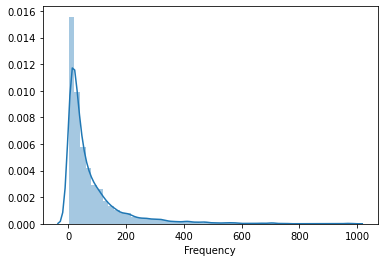

In [ ]:
x = RFM_Scores.query('Frequency < 1000')['Frequency']

ax = sns.distplot(x)

In [ ]:
RFM_Scores.Monetary.describe()

count      3921.000000
mean       1863.910113
std        7481.922217
min           0.000000
25%         300.040000
50%         651.820000
75%        1575.890000
max      259657.300000
Name: Monetary, dtype: float64

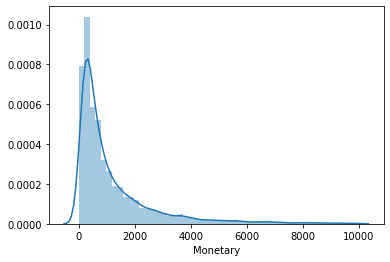

In [ ]:
x = RFM_Scores.query('Monetary < 10000')['Monetary']

ax = sns.distplot(x)

In [ ]:
quantiles = RFM_Scores.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [ ]:
quantiles

{'Frequency': {0.25: 17.0, 0.5: 41.0, 0.75: 99.0},
 'Monetary': {0.25: 300.03999999999996, 0.5: 651.8199999999999, 0.75: 1575.89},
 'Recency': {0.25: 17.0, 0.5: 50.0, 0.75: 142.0}}

In [ ]:
def RScoring(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FnMScoring(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [ ]:
RFM_Scores['R'] = RFM_Scores['Recency'].apply(RScoring, args=('Recency',quantiles,))
RFM_Scores['F'] = RFM_Scores['Frequency'].apply(FnMScoring, args=('Frequency',quantiles,))
RFM_Scores['M'] = RFM_Scores['Monetary'].apply(FnMScoring, args=('Monetary',quantiles,))
RFM_Scores.head()

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12346.0,325,1,77183.60,4,4,1
12747.0,2,103,4196.01,1,1,1
12748.0,0,4596,33719.73,1,1,1
12749.0,3,199,4090.88,1,1,1
12820.0,3,59,942.34,1,2,2


In [ ]:
RFM_Scores['RFMGroup'] = RFM_Scores.R.map(str) + RFM_Scores.F.map(str) + RFM_Scores.M.map(str)
RFM_Scores['RFMScore'] = RFM_Scores[['R', 'F', 'M']].sum(axis = 1)
RFM_Scores.head()

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore
CustomerID,,,,,,,,
12346.0,325,1,77183.60,4,4,1,441,9
12747.0,2,103,4196.01,1,1,1,111,3
12748.0,0,4596,33719.73,1,1,1,111,3
12749.0,3,199,4090.88,1,1,1,111,3
12820.0,3,59,942.34,1,2,2,122,5


In [ ]:
Loyalty_Level = ['Platinum', 'Gold', 'Silver', 'Bronze']
Score_cuts = pd.qcut(RFM_Scores.RFMScore, q = 4, labels = Loyalty_Level)
RFM_Scores['RFM_Loyalty_Level'] = Score_cuts.values
RFM_Scores.reset_index().head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,12346.0,325,1,77183.60,4,4,1,441,9,Silver
1,12747.0,2,103,4196.01,1,1,1,111,3,Platinum
2,12748.0,0,4596,33719.73,1,1,1,111,3,Platinum
3,12749.0,3,199,4090.88,1,1,1,111,3,Platinum
4,12820.0,3,59,942.34,1,2,2,122,5,Platinum


In [ ]:
RFM_Scores[RFM_Scores['RFMGroup']=='111'].sort_values('Monetary', ascending=False).reset_index().head(10)

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,18102.0,0,431,259657.30,1,1,1,111,3,Platinum
1,17450.0,8,337,194550.79,1,1,1,111,3,Platinum
2,17511.0,2,963,91062.38,1,1,1,111,3,Platinum
3,16684.0,4,277,66653.56,1,1,1,111,3,Platinum
4,14096.0,4,5111,65164.79,1,1,1,111,3,Platinum
5,13694.0,3,568,65039.62,1,1,1,111,3,Platinum
6,15311.0,0,2379,60767.90,1,1,1,111,3,Platinum
7,13089.0,2,1818,58825.83,1,1,1,111,3,Platinum
8,15769.0,7,130,56252.72,1,1,1,111,3,Platinum
9,15061.0,3,403,54534.14,1,1,1,111,3,Platinum


In [ ]:
RFM_Scores.head()

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
CustomerID,,,,,,,,,
12346.0,325,1,77183.60,4,4,1,441,9,Silver
12747.0,2,103,4196.01,1,1,1,111,3,Platinum
12748.0,0,4596,33719.73,1,1,1,111,3,Platinum
12749.0,3,199,4090.88,1,1,1,111,3,Platinum
12820.0,3,59,942.34,1,2,2,122,5,Platinum


In [ ]:
!pip install chart_studio

     |████████████████████████████████| 71kB 2.6MB/s 


In [ ]:
import chart_studio as cs
import plotly.offline as po
import plotly.graph_objs as gobj

#Recency Vs Frequency
graph = RFM_Scores.query("Monetary < 50000 and Frequency < 2000")

plot_data = [
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Bronze'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Bronze'")['Frequency'],
        mode='markers',
        name='Bronze',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Silver'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Silver'")['Frequency'],
        mode='markers',
        name='Silver',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Gold'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Gold'")['Frequency'],
        mode='markers',
        name='Gold',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Platinum'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Platinum'")['Frequency'],
        mode='markers',
        name='Platinum',
        marker= dict(size= 13,
            line= dict(width=1),
            color= 'black',
            opacity= 0.9
           )
    ),
]

plot_layout = gobj.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = gobj.Figure(data=plot_data, layout=plot_layout)
po.iplot(fig)


In [ ]:
#Frequency Vs Monetary
graph = RFM_Scores.query("Monetary < 50000 and Frequency < 2000")

plot_data = [
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Bronze'")['Frequency'],
        y=graph.query("RFM_Loyalty_Level == 'Bronze'")['Monetary'],
        mode='markers',
        name='Bronze',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Silver'")['Frequency'],
        y=graph.query("RFM_Loyalty_Level == 'Silver'")['Monetary'],
        mode='markers',
        name='Silver',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Gold'")['Frequency'],
        y=graph.query("RFM_Loyalty_Level == 'Gold'")['Monetary'],
        mode='markers',
        name='Gold',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Platinum'")['Frequency'],
        y=graph.query("RFM_Loyalty_Level == 'Platinum'")['Monetary'],
        mode='markers',
        name='Platinum',
        marker= dict(size= 13,
            line= dict(width=1),
            color= 'black',
            opacity= 0.9
           )
    ),
]

plot_layout = gobj.Layout(
        yaxis= {'title': "Monetary"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = gobj.Figure(data=plot_data, layout=plot_layout)
po.iplot(fig)



In [ ]:
#Recency Vs Monetary
graph = RFM_Scores.query("Monetary < 50000 and Frequency < 2000")

plot_data = [
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Bronze'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Bronze'")['Monetary'],
        mode='markers',
        name='Bronze',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Silver'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Silver'")['Monetary'],
        mode='markers',
        name='Silver',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Gold'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Gold'")['Monetary'],
        mode='markers',
        name='Gold',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Platinum'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Platinum'")['Monetary'],
        mode='markers',
        name='Platinum',
        marker= dict(size= 13,
            line= dict(width=1),
            color= 'black',
            opacity= 0.9
           )
    ),
]

plot_layout = gobj.Layout(
        yaxis= {'title': "Monetary"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = gobj.Figure(data=plot_data, layout=plot_layout)
po.iplot(fig)

In [ ]:
#K-Means Clustering
def handle_neg_n_zero(num):
    if num <= 0:
        return 1
    else:
        return num
 
RFM_Scores['Recency'] = [handle_neg_n_zero(x) for x in RFM_Scores.Recency]
RFM_Scores['Monetary'] = [handle_neg_n_zero(x) for x in RFM_Scores.Monetary]

Log_Tfd_Data = RFM_Scores[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)

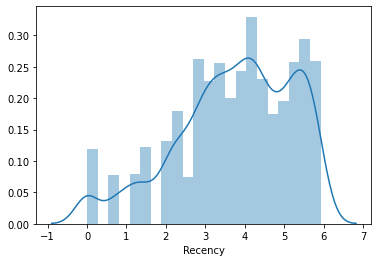

In [ ]:
Recency_Plot = Log_Tfd_Data['Recency']
ax = sns.distplot(Recency_Plot)

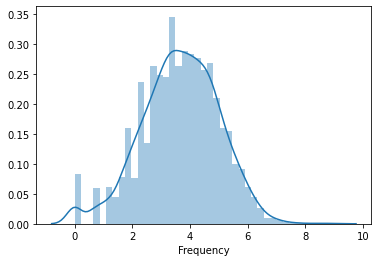

In [ ]:
Frequency_Plot = Log_Tfd_Data.query('Frequency < 1000')['Frequency']
ax = sns.distplot(Frequency_Plot)

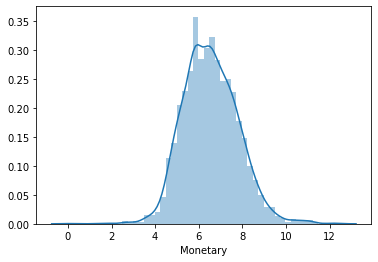

In [ ]:
Monetary_Plot = Log_Tfd_Data.query('Monetary < 10000')['Monetary']
ax = sns.distplot(Monetary_Plot)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaleobj = StandardScaler()
Scaled_Data = scaleobj.fit_transform(Log_Tfd_Data)

Scaled_Data = pd.DataFrame(Scaled_Data, index = RFM_Scores.index, columns = Log_Tfd_Data.columns)

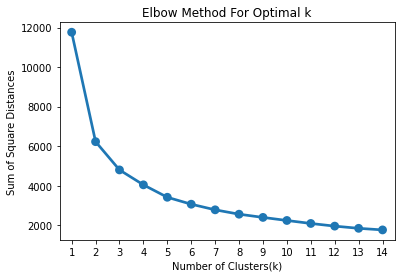

In [ ]:
from sklearn.cluster import KMeans

sum_of_sq_dist = {}
for k in range(1,15):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    km = km.fit(Scaled_Data)
    sum_of_sq_dist[k] = km.inertia_
    
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
KMean_clust = KMeans(n_clusters= 3, init= 'k-means++', max_iter= 1000)
KMean_clust.fit(Scaled_Data)

RFM_Scores['Cluster'] = KMean_clust.labels_
RFM_Scores.head()

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level,Cluster
CustomerID,,,,,,,,,,
12346.0,325,1,77183.60,4,4,1,441,9,Silver,0
12747.0,2,103,4196.01,1,1,1,111,3,Platinum,2
12748.0,1,4596,33719.73,1,1,1,111,3,Platinum,2
12749.0,3,199,4090.88,1,1,1,111,3,Platinum,2
12820.0,3,59,942.34,1,2,2,122,5,Platinum,2


<Figure size 504x504 with 0 Axes>

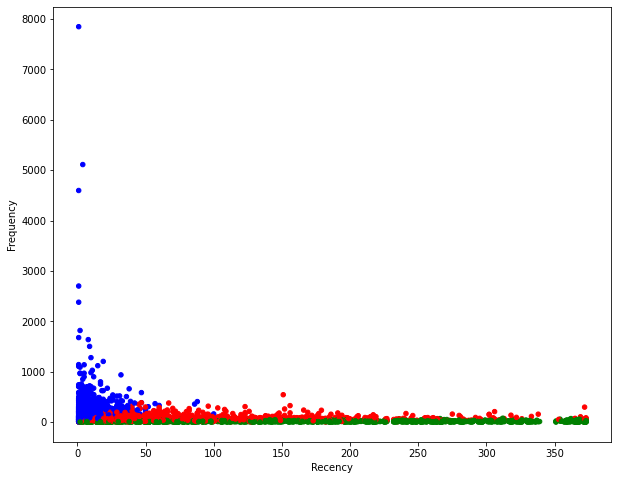

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(7,7))

Colors = ["red", "green", "blue"]
RFM_Scores['Color'] = RFM_Scores['Cluster'].map(lambda p: Colors[p])
ax = RFM_Scores.plot(    
    kind="scatter", 
    x="Recency", y="Frequency",
    figsize=(10,8),
    c = RFM_Scores['Color']
)

In [ ]:
RFM_Scores.head()

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level,Cluster,Color
CustomerID,,,,,,,,,,,
12346.0,325,1,77183.60,4,4,1,441,9,Silver,0,red
12747.0,2,103,4196.01,1,1,1,111,3,Platinum,2,blue
12748.0,1,4596,33719.73,1,1,1,111,3,Platinum,2,blue
12749.0,3,199,4090.88,1,1,1,111,3,Platinum,2,blue
12820.0,3,59,942.34,1,2,2,122,5,Platinum,2,blue


In [ ]:
Scaled_Data.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,1.389971,-2.733639,3.766415
12747.0,-2.061189,0.726978,1.439009
12748.0,-2.530970,3.562667,3.104639
12749.0,-1.785964,1.218258,1.419028
12820.0,-1.785964,0.311106,0.244935


In [ ]:

#CLV
tx_data['InvoiceDate'] = pd.to_datetime(tx_data['InvoiceDate'], format="%m/%d/%Y %H:%M").dt.date

tx_data = tx_data[pd.notnull(tx_data['CustomerID'])]
tx_data = tx_data[(tx_data['Quantity']>0)]

tx_data['Total_Sales'] = tx_data['Quantity'] * tx_data['UnitPrice']
necessary_cols = ['CustomerID', 'InvoiceDate', 'Total_Sales']
tx_data = tx_data[necessary_cols]
tx_data.head()

,CustomerID,InvoiceDate,Total_Sales
0,17850.0,2010-12-01,15.30
1,17850.0,2010-12-01,20.34
2,17850.0,2010-12-01,22.00
3,17850.0,2010-12-01,20.34
4,17850.0,2010-12-01,20.34


In [ ]:
print(tx_data['CustomerID'].nunique())

4339


In [ ]:
last_order_date = tx_data['InvoiceDate'].max()
print(last_order_date)
print("--------------------------------------")
print(tx_data[(tx_data['CustomerID']==12346)])

2011-12-09
--------------------------------------
       CustomerID InvoiceDate  Total_Sales
61619     12346.0  2011-01-18      77183.6


In [ ]:
!pip install lifetimes
from lifetimes.plotting import *
from lifetimes.utils import *

lf_tx_data = summary_data_from_transaction_data(tx_data, 'CustomerID', 'InvoiceDate', monetary_value_col='Total_Sales', observation_period_end='2011-12-9')
lf_tx_data.reset_index().head()

     |████████████████████████████████| 583kB 3.3MB/s 


,CustomerID,frequency,recency,T,monetary_value
0,12346.0,0.0,0.0,325.0,0.000000
1,12347.0,6.0,365.0,367.0,599.701667
2,12348.0,3.0,283.0,358.0,301.480000
3,12349.0,0.0,0.0,18.0,0.000000
4,12350.0,0.0,0.0,310.0,0.000000


count    4339.000000
mean        2.864024
std         5.952745
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       131.000000
Name: frequency, dtype: float64
---------------------------------------
Percentage of customers purchase the item only once: 35.7 %


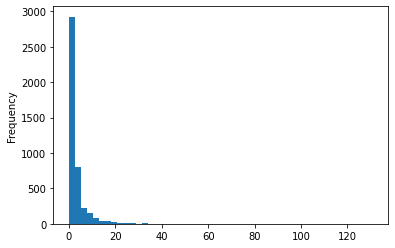

In [ ]:
%matplotlib inline
lf_tx_data['frequency'].plot(kind='hist', bins=50)
print(lf_tx_data['frequency'].describe())
print("---------------------------------------")
one_time_buyers = round(sum(lf_tx_data['frequency'] == 0)/float(len(lf_tx_data))*(100),2)
print("Percentage of customers purchase the item only once:", one_time_buyers ,"%")

In [ ]:
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(lf_tx_data['frequency'], lf_tx_data['recency'], lf_tx_data['T'])

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.89, b: 6.75, r: 0.83>


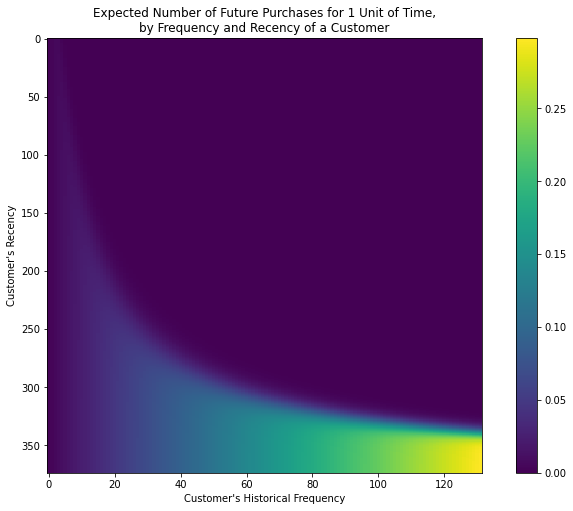

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from lifetimes.plotting import plot_frequency_recency_matrix
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

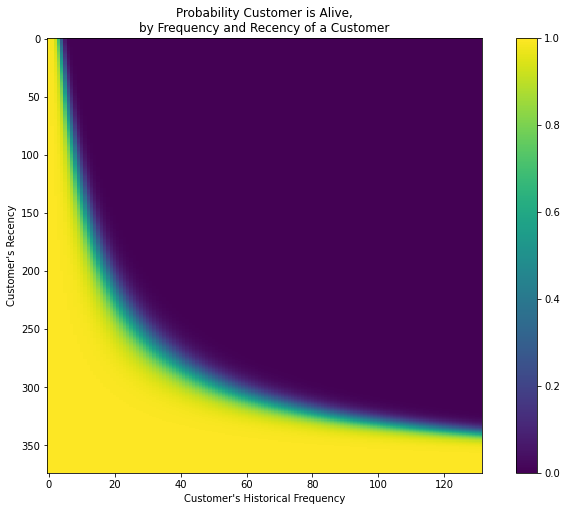

In [ ]:
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

In [ ]:
t = 10
lf_tx_data['pred_num_txn'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(t, lf_tx_data['frequency'], lf_tx_data['recency'], lf_tx_data['T']),2)
lf_tx_data.sort_values(by='pred_num_txn', ascending=False).head(10).reset_index()

,CustomerID,frequency,recency,T,monetary_value,pred_num_txn
0,14911.0,131.0,372.0,373.0,1093.661679,2.98
1,12748.0,113.0,373.0,373.0,298.360885,2.58
2,17841.0,111.0,372.0,373.0,364.452162,2.53
3,15311.0,89.0,373.0,373.0,677.729438,2.03
4,14606.0,88.0,372.0,373.0,135.890114,2.01
5,12971.0,70.0,369.0,372.0,159.211286,1.61
6,13089.0,65.0,367.0,369.0,893.714308,1.50
7,14527.0,53.0,367.0,369.0,155.016415,1.23
8,13798.0,52.0,371.0,372.0,706.650962,1.20
9,16422.0,47.0,352.0,369.0,702.472340,1.09


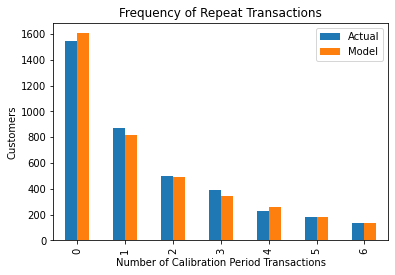

In [ ]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [ ]:
t = 10
individual = lf_tx_data.loc[14911]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

2.9830238639021625

In [ ]:
lf_tx_data[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.046161
frequency,0.046161,1.000000


In [ ]:
shortlisted_customers = lf_tx_data[lf_tx_data['frequency']>0]
print(shortlisted_customers.head().reset_index())
print("-----------------------------------------")
print("The Number of Returning Customers are: ",len(shortlisted_customers))

   CustomerID  frequency  recency      T  monetary_value  pred_num_txn
0     12347.0        6.0    365.0  367.0      599.701667          0.16
1     12348.0        3.0    283.0  358.0      301.480000          0.09
2     12352.0        6.0    260.0  296.0      368.256667          0.19
3     12356.0        2.0    303.0  325.0      269.905000          0.07
4     12358.0        1.0    149.0  150.0      683.200000          0.08
-----------------------------------------
The Number of Returning Customers are:  2790


In [ ]:
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(shortlisted_customers['frequency'],
        shortlisted_customers['monetary_value'])


<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>

In [ ]:
print(ggf.conditional_expected_average_profit(
        lf_tx_data['frequency'],
        lf_tx_data['monetary_value']
    ).head(10))

CustomerID
12346.0    416.917667
12347.0    569.988807
12348.0    333.762672
12349.0    416.917667
12350.0    416.917667
12352.0    376.166864
12353.0    416.917667
12354.0    416.917667
12355.0    416.917667
12356.0    324.008941
dtype: float64


In [ ]:
lf_tx_data['pred_txn_value'] = round(ggf.conditional_expected_average_profit(
        lf_tx_data['frequency'],
        lf_tx_data['monetary_value']), 2)
lf_tx_data.reset_index().head()

,CustomerID,frequency,recency,T,monetary_value,pred_num_txn,pred_txn_value
0,12346.0,0.0,0.0,325.0,0.000000,0.02,416.92
1,12347.0,6.0,365.0,367.0,599.701667,0.16,569.99
2,12348.0,3.0,283.0,358.0,301.480000,0.09,333.76
3,12349.0,0.0,0.0,18.0,0.000000,0.10,416.92
4,12350.0,0.0,0.0,310.0,0.000000,0.02,416.92


In [ ]:
lf_tx_data['CLV'] = round(ggf.customer_lifetime_value(
    bgf, 
    lf_tx_data['frequency'],
    lf_tx_data['recency'],
    lf_tx_data['T'],
    lf_tx_data['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
), 2)

lf_tx_data.drop(lf_tx_data.iloc[:, 0:6], inplace=True, axis=1)

lf_tx_data.sort_values(by='CLV', ascending=False).head(10).reset_index()

,CustomerID,CLV
0,14646.0,222128.93
1,18102.0,178895.33
2,16446.0,175531.47
3,17450.0,147476.62
4,14096.0,127589.20
5,14911.0,109442.13
6,12415.0,96290.23
7,14156.0,89410.33
8,17511.0,67660.41
9,16029.0,58729.62
